In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

In [2]:
### Mounting Google drive
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/CSI/Notebook

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Mounted at /gdrive
/gdrive/MyDrive/CSI/Notebook


In [3]:
num_participants = 15

def import_accelerometer_timeseries(window_size=200, seed=seed):

    dataframes = []
    for i in range(num_participants):
        path = f"/gdrive/MyDrive/CSI/Notebook/datasets/Activity Recognition from Single Chest-Mounted Accelerometer/{i+1}.csv"
        df = pd.read_csv(path, header=None)
        df.columns = ["pos", "x", "y", "z", "action"]
        df = df.drop("pos", axis=1)
        dataframes.append(df)

    X = []
    Y = []
    #### pre-processing ####
    for df in dataframes:
        arr = df.to_numpy()

        ### split the signal of each participant based on the activity performed ###
        for c in range(1, 8):
            class_signal = arr[arr[:, 3] == c][:, :3]

            if class_signal.shape[0] == 0:
                continue

            idx = 0
            n = class_signal.shape[0]

            ## window the signal ##

            while idx < n:
                window = class_signal[idx: idx + window_size]

                # padding if shorter
                if window.shape[0] < window_size:
                    pad_len = window_size - window.shape[0]
                    window = np.pad(window, ((0, pad_len), (0, 0)), mode='constant', constant_values=0)

                X.append(window)
                Y.append(c - 1)

                idx += window_size

    X = np.array(X)  # shape: (num_seq, window_size, 3)
    Y = np.array(Y)
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    X = X[indices]
    Y = Y[indices]

    ## Train 70% / Val 10% and Test 20%
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=0.30, stratify=Y, random_state=seed
    )

    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=2/3, stratify=Y_temp, random_state=seed
    )

    ## Standardization column-wise
    mean = X_train.mean(axis=(0,1))
    std  = X_train.std(axis=(0,1))

    X_train = (X_train - mean) / std
    X_val   = (X_val   - mean) / std
    X_test  = (X_test  - mean) / std

    return X_train, X_val, X_test, Y_train, Y_val, Y_test


In [4]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = import_accelerometer_timeseries()

Y_train = tfk.utils.to_categorical(Y_train)
Y_val = tfk.utils.to_categorical(Y_val)
Y_test = tfk.utils.to_categorical(Y_test)

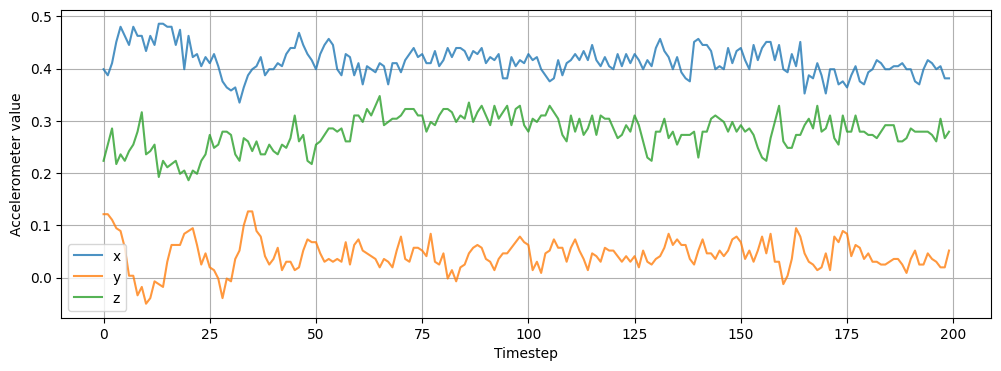

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_sequence(X, Y, idx=0):
    sample = X[idx]
    label = Y[idx]
    real_len = np.argmax(np.all(sample == 0, axis=1))
    if real_len == 0:
        real_len = sample.shape[0]

    t = np.arange(real_len)

    plt.figure(figsize=(12,4))
    plt.plot(t, sample[:real_len, 0], label="x", alpha=0.8)
    plt.plot(t, sample[:real_len, 1], label="y", alpha=0.8)
    plt.plot(t, sample[:real_len, 2], label="z", alpha=0.8)

    plt.xlabel("Timestep")
    plt.ylabel("Accelerometer value")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_sample_sequence(X_train, Y_train, idx=7)


In [7]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

classes = 7

# Set the batch size for training
batch_size = 128  # is the number of samples processed together by the model before updating its weights during training
### the higher the batch_size the more stable is the training --> trade-off with computational resources

# Set the number of epochs for training
epochs = 200    # is the number of iterations across the entire training dataset


In [14]:
input_shape

(200, 3)

# LSTM

In [8]:
def build_LSTM_classifier(input_shape, classes):
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.LSTM(128, return_sequences=True, name='lstm_0')(input_layer)
    x = tfkl.BatchNormalization(name='batch_norm_0')(x)
    x = tfkl.LSTM(128, return_sequences=True, name='lstm_1')(x)
    x = tfkl.BatchNormalization(name='batch_norm_1')(x)
    x = tfkl.LSTM(128, name='lstm_2')(x)
    x = tfkl.BatchNormalization(name='batch_norm_2')(x)
    x = tfkl.Dropout(0.5, name='dropout')(x)
    x = tfkl.Dense(128, name='dense_hidden')(x)
    x = tfkl.BatchNormalization(name='dense_hidden_batch_norm')(x)
    x = tfkl.Activation('relu', name='dense_hidden_activation')(x)

    x = tfkl.Dense(classes, name='dense_output')(x)
    output_layer = tfkl.Activation('softmax', name='dense_output_activation')(x)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['accuracy']
    )

    return model


In [ ]:
# Build the LSTM classifier model
model = build_LSTM_classifier(input_shape, classes)


In [10]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        ### patience = how many epochs it waits before stopping the training after the detection
        ### of a decrease in the val accuracy

        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'LSTM_Activity_Classifier_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3906 - loss: 1.6590 - val_accuracy: 0.3364 - val_loss: 1.7723 - learning_rate: 0.0010
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6531 - loss: 1.0639 - val_accuracy: 0.3861 - val_loss: 1.7286 - learning_rate: 0.0010
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6735 - loss: 0.9755 - val_accuracy: 0.4089 - val_loss: 1.6944 - learning_rate: 0.0010
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.6863 - loss: 0.9384 - val_accuracy: 0.4689 - val_loss: 1.4876 - learning_rate: 0.0010
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.6891 - loss: 0.9397 - val_accuracy: 0.6025 - val_loss: 1.1820 - learning_rate: 0.0010
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7040 - loss: 0.9007 - val_accuracy: 0.6242 - val_loss: 1.1359 - learning_rate: 0.0010
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7180 - loss: 0.8678 - 

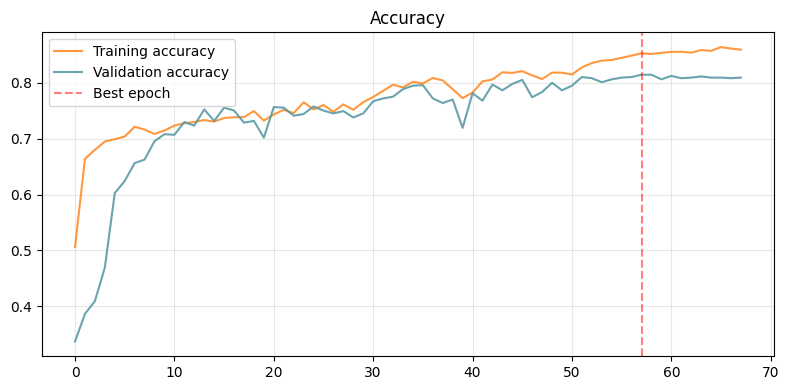

In [28]:
# Identify the epoch with the best validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Create a figure with 3 vertical subplots
fig, (ax2) = plt.subplots(1, 1, figsize=(8, 4))


# Plot 2: Accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=0.8, color='#ff7f0e')
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=0.9, color='#5a9aa5')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=0.5, linestyle='--', color='red')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)



# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [6]:
# Predict the test set with the LSTM
model = tfk.models.load_model('LSTM_Activity_Classifier_81.47.keras')
predictions = model.predict(X_test, verbose=0)
predictions.shape

y_test = Y_test

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Test Accuracy:',round(accuracy,4))



Test Accuracy: 0.8014


## 1D CNN

In [32]:
# Define a function to build a 1D CNN-based classifier
def build_1DCNN_classifier(input_shape, classes):
    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Add feature extractor layers
    x = tfkl.Conv1D(128, 3, padding='same', name='conv1d_0')(input_layer)
    x = tfkl.BatchNormalization(name='batch_norm_0')(x)
    x = tfkl.Activation('relu', name='activation_0')(x)
    x = tfkl.MaxPooling1D(name='max_pooling_0')(x)

    x = tfkl.Conv1D(128, 3, padding='same', name='conv1d_1')(x)
    x = tfkl.BatchNormalization(name='batch_norm_1')(x)
    x = tfkl.Activation('relu', name='activation_1')(x)
    x = tfkl.MaxPooling1D(name='max_pooling_1')(x)

    x = tfkl.Conv1D(128, 3, padding='same', name='conv1d_2')(x)
    x = tfkl.BatchNormalization(name='batch_norm_2')(x)
    x = tfkl.Activation('relu', name='activation_2')(x)
    x = tfkl.GlobalAveragePooling1D(name='gap')(x)

    # Add dropout for regularisation
    x = tfkl.Dropout(0.5, name='dropout')(x)

    # Add classifier layers
    x = tfkl.Dense(128, name='dense_hidden')(x)
    x = tfkl.BatchNormalization(name='dense_hidden_batch_norm')(x)
    x = tfkl.Activation('relu', name='dense_hidden_activation')(x)

    x = tfkl.Dense(classes, name='dense_output')(x)
    output_layer = tfkl.Activation('softmax', name='dense_output_activation')(x)

    # Create the model by connecting input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model with categorical crossentropy loss and Adam optimiser
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(),
        metrics=['accuracy']
    )

    # Return the compiled model
    return model

In [33]:
# Build the 1D CNN classifier model
model = build_1DCNN_classifier(input_shape, classes)


In [34]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = '1DCNN_Activity_Classifier_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 294ms/step - accuracy: 0.4444 - loss: 1.6015 - val_accuracy: 0.4182 - val_loss: 1.6182 - learning_rate: 0.0010
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.6498 - loss: 1.0586 - val_accuracy: 0.3830 - val_loss: 1.7087 - learning_rate: 0.0010
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 20s 288ms/step - accuracy: 0.6861 - loss: 0.9806 - val_accuracy: 0.4017 - val_loss: 1.7248 - learning_rate: 0.0010
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 284ms/step - accuracy: 0.7074 - loss: 0.9196 - val_accuracy: 0.4472 - val_loss: 1.5722 - learning_rate: 0.0010
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 15s 290ms/step - accuracy: 0.7091 - loss: 0.8837 - val_accuracy: 0.5238 - val_loss: 1.3526 - learning_rate: 0.0010
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 21s 304ms/step - accuracy: 0.7169 - loss: 0.8694 - val_accuracy: 0.6004 - val_loss: 1.1198 - learning_rate: 0.0010
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 19s 287ms/step - accuracy: 0.7163 - l

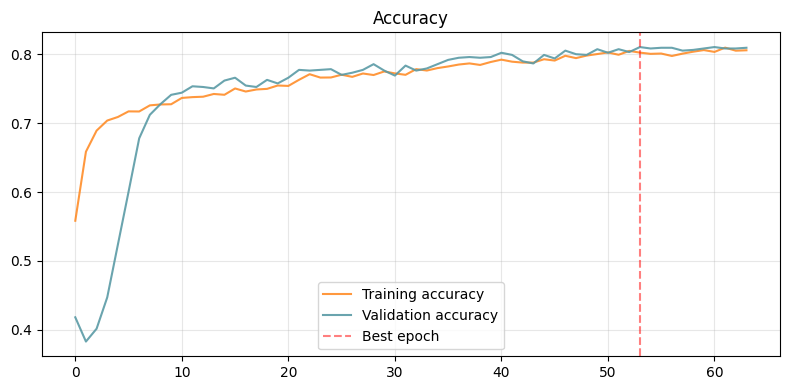

In [35]:
# Identify the epoch with the best validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

fig, (ax2) = plt.subplots(1, 1, figsize=(8, 4))

# Plot 2: Accuracy
ax2.plot(history['accuracy'], label='Training accuracy', alpha=0.8, color='#ff7f0e')
ax2.plot(history['val_accuracy'], label='Validation accuracy', alpha=0.9, color='#5a9aa5')
ax2.axvline(x=best_epoch, label='Best epoch', alpha=0.5, linestyle='--', color='red')
ax2.set_title('Accuracy')
ax2.legend()
ax2.grid(alpha=0.3)



# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

In [40]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict the test set with the LSTM
model = tfk.models.load_model('1DCNN_Activity_Classifier_81.06.keras')
predictions = model.predict(X_test, verbose=0)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Test Accuracy:',round(accuracy,4))




Test Accuracy: 0.8092


# RNN

In [8]:
def build_RNN_classifier(input_shape, classes):
    input_layer = tf.keras.layers.Input(shape=input_shape, name='Input')

    # First RNN layer
    x = tf.keras.layers.SimpleRNN(128, return_sequences=True, name='rnn_0')(input_layer)
    x = tf.keras.layers.BatchNormalization(name='bn_0')(x)

    # Second RNN layer
    x = tf.keras.layers.SimpleRNN(128, return_sequences=True, name='rnn_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_1')(x)

    # Final RNN layer (no return_sequences)
    x = tf.keras.layers.SimpleRNN(128, name='rnn_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_2')(x)

    # Dropout
    x = tf.keras.layers.Dropout(0.5)(x)

    # Dense classifier
    x = tf.keras.layers.Dense(128, activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)

    output = tf.keras.layers.Dense(classes, activation="softmax")(x)

    model = tf.keras.models.Model(input_layer, output)

    model.compile(
        optimizer="adam",
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"]
    )

    return model


In [9]:

model = build_RNN_classifier(input_shape, classes=classes)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_0 (SimpleRNN)               │ (None, 200, 128)       │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 200, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (SimpleRNN)               │ (None, 200, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 200, 128)       │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_2 (SimpleRNN)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,151 (399.03 KB)

 Trainable params: 101,127 (395.03 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [44]:
# Train the model
history = model.fit(
    x = X_train,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, Y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'RNN_Activity_Classifier_'+str(final_val_accuracy)+'.keras'
model.save(model_filename)


Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.2954 - loss: 2.0661 - val_accuracy: 0.4658 - val_loss: 1.6254 - learning_rate: 0.0010
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 70s 910ms/step - accuracy: 0.5539 - loss: 1.3700 - val_accuracy: 0.4886 - val_loss: 1.6942 - learning_rate: 0.0010
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 50s 953ms/step - accuracy: 0.5825 - loss: 1.3076 - val_accuracy: 0.4120 - val_loss: 1.5396 - learning_rate: 0.0010
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 81s 931ms/step - accuracy: 0.5405 - loss: 1.3287 - val_accuracy: 0.4741 - val_loss: 1.4519 - learning_rate: 0.0010
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 47s 889ms/step - accuracy: 0.5884 - loss: 1.2249 - val_accuracy: 0.6263 - val_loss: 1.0884 - learning_rate: 0.0010
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 82s 889ms/step - accuracy: 0.6233 - loss: 1.1359 - val_accuracy: 0.6190 - val_loss: 1.0912 - learning_rate: 0.0010
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 49s 922ms/step - accuracy: 0.6271 - loss

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Predict the test set with the LSTM
model = tfk.models.load_model('RNN_Activity_Classifier_73.08.keras')
predictions = model.predict(X_test, verbose=0)
predictions.shape
y_test = Y_test
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Test Accuracy:',round(accuracy,4))




Test Accuracy: 0.7265


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
